# Advanced usage

This notebook replicates what was done in the *simple_usage* notebooks, but this time with the advanced API. The advanced API is required if we want to use non-standard affinity methods that better preserve global structure.

If you are comfortable with the advanced API, please refer to the *preserving_global_structure* notebook for a guide how obtain better embeddings and preserve more global structure.

In [1]:
from openTSNE import TSNEEmbedding
from openTSNE.affinity import PerplexityBasedNN
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/macosko_2015.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


## Create train/test split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [5]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

30021 training samples
14787 test samples


## Create a t-SNE embedding

Like in the *simple_usage* notebook, we will run the standard t-SNE optimization.

This example shows the standard t-SNE optimization. Much can be done in order to better preserve global structure and improve embedding quality. Please refer to the *preserving_global_structure* notebook for some examples.

**1. Compute the affinities between data points**

In [6]:
%%time
affinities_train = PerplexityBasedNN(
    x_train,
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
)

CPU times: user 1min 39s, sys: 2.15 s, total: 1min 41s
Wall time: 19.6 s


**2. Generate initial coordinates for our embedding**

In [7]:
%time init_train = initialization.pca(x_train, random_state=42)

CPU times: user 3.01 s, sys: 49.6 ms, total: 3.06 s
Wall time: 77.3 ms


**3. Construct the `TSNEEmbedding` object**

In [8]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

**4. Optimize embedding**

1. Early exaggeration phase

In [9]:
%time embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  5.7889, 50 iterations in 1.1595 sec
Iteration  100, KL divergence  5.2496, 50 iterations in 1.1852 sec
Iteration  150, KL divergence  5.1563, 50 iterations in 1.1364 sec
Iteration  200, KL divergence  5.1203, 50 iterations in 1.1426 sec
Iteration  250, KL divergence  5.1018, 50 iterations in 1.1117 sec
CPU times: user 2min 52s, sys: 3.41 s, total: 2min 55s
Wall time: 5.79 s


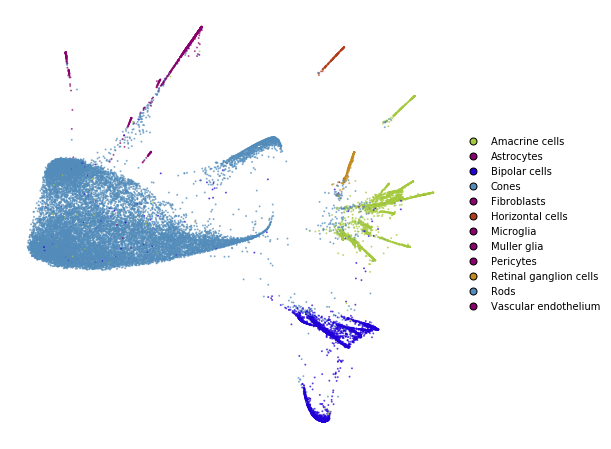

In [10]:
utils.plot(embedding_train_1, y_train, colors=utils.MACOSKO_COLORS)

2. Regular optimization

In [11]:
%time embedding_train_2 = embedding_train_1.optimize(n_iter=750, momentum=0.8)

Iteration   50, KL divergence  3.7958, 50 iterations in 1.3252 sec
Iteration  100, KL divergence  3.4076, 50 iterations in 1.2355 sec
Iteration  150, KL divergence  3.1945, 50 iterations in 1.4455 sec
Iteration  200, KL divergence  3.0541, 50 iterations in 1.4912 sec
Iteration  250, KL divergence  2.9521, 50 iterations in 1.9103 sec
Iteration  300, KL divergence  2.8745, 50 iterations in 2.1101 sec
Iteration  350, KL divergence  2.8131, 50 iterations in 2.6402 sec
Iteration  400, KL divergence  2.7642, 50 iterations in 3.6373 sec
Iteration  450, KL divergence  2.7241, 50 iterations in 3.8347 sec
Iteration  500, KL divergence  2.6918, 50 iterations in 4.7176 sec
Iteration  550, KL divergence  2.6655, 50 iterations in 6.8521 sec
Iteration  600, KL divergence  2.6441, 50 iterations in 5.5079 sec
Iteration  650, KL divergence  2.6264, 50 iterations in 6.5560 sec
Iteration  700, KL divergence  2.6121, 50 iterations in 7.5798 sec
Iteration  750, KL divergence  2.6002, 50 iterations in 9.0642

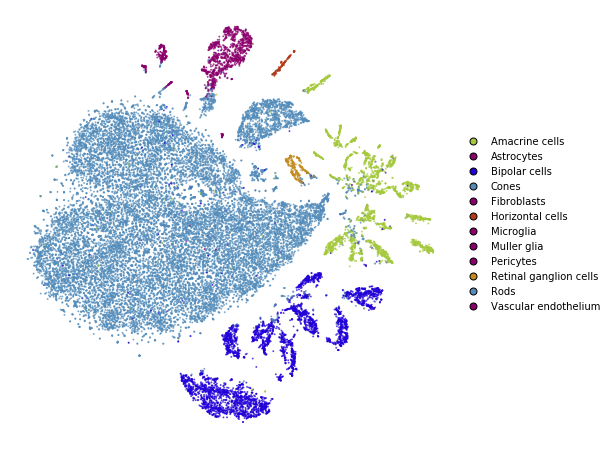

In [12]:
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS)

## Transform

In [13]:
%%time
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)

CPU times: user 3.55 s, sys: 150 ms, total: 3.7 s
Wall time: 1.22 s


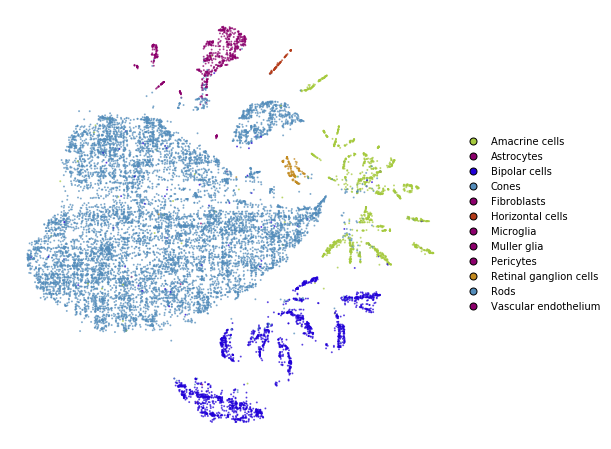

In [14]:
utils.plot(embedding_test, y_test, colors=utils.MACOSKO_COLORS)

In [15]:
%%time
embedding_test_1 = embedding_test.optimize(
    n_iter=100,
    learning_rate=1,
    exaggeration=2,
    momentum=0,
)

Iteration   50, KL divergence  212577.9338, 50 iterations in 8.4328 sec
Iteration  100, KL divergence  212507.1902, 50 iterations in 6.1227 sec
CPU times: user 3min 14s, sys: 3.71 s, total: 3min 18s
Wall time: 14.7 s


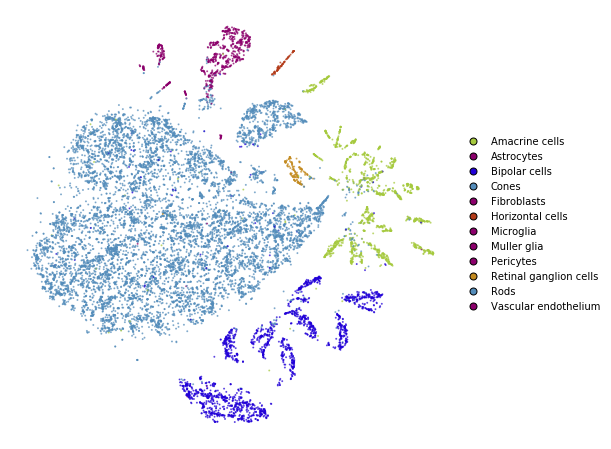

In [16]:
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS)

## Together

We superimpose the transformed points onto the original embedding with larger opacity.

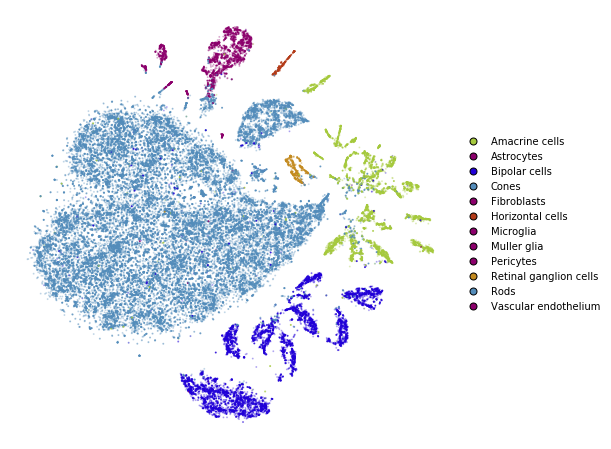

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
utils.plot(embedding_train_2, y_train, colors=utils.MACOSKO_COLORS, alpha=0.25, ax=ax)
utils.plot(embedding_test_1, y_test, colors=utils.MACOSKO_COLORS, alpha=0.75, ax=ax)